In [1]:
# todo: playing around with data, we realize we probably want to filter out any trips with negative amounts

# end-to-end, this analysis would look like....

In [1]:
import duckboat as uck

In [3]:
t1 = uck.Table('data/yellow_tripdata_2010-01.parquet', defer_repr=True)
t1

<A Table Object we do not want to materialize just yet>

In [4]:
uck.Table(t1)

┌───────────┬─────────────────────┬─────────────────────┬─────────────────┬────────────────────┬────────────────────┬─────────────────┬───────────┬────────────────────┬────────────────────┬──────────────────┬──────────────┬───────────────────┬───────────┬─────────┬────────────┬──────────────┬──────────────┐
│ vendor_id │   pickup_datetime   │  dropoff_datetime   │ passenger_count │   trip_distance    │  pickup_longitude  │ pickup_latitude │ rate_code │ store_and_fwd_flag │ dropoff_longitude  │ dropoff_latitude │ payment_type │    fare_amount    │ surcharge │ mta_tax │ tip_amount │ tolls_amount │ total_amount │
│  varchar  │       varchar       │       varchar       │      int64      │       double       │       double       │     double      │  varchar  │      varchar       │       double       │      double      │   varchar    │      double       │  double   │ double  │   double   │    double    │    double    │
├───────────┼─────────────────────┼─────────────────────┼────────────────

In [14]:
t2 = uck.Table('data/yellow_tripdata_2010-02.parquet')
t1.do(
    avg_func,
    'select int(log10(num))'
)

NameError: name 'avg_func' is not defined

In [4]:
t1.columns

['vendor_id',
 'pickup_datetime',
 'dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'pickup_longitude',
 'pickup_latitude',
 'rate_code',
 'store_and_fwd_flag',
 'dropoff_longitude',
 'dropoff_latitude',
 'payment_type',
 'fare_amount',
 'surcharge',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'total_amount']

# Transforming data interactively

In [5]:
# You can use standard duckdb SQL expressions. The `from <table_name>` is automatically inserted for you, so it should be omitted.
# `select ...` is optional. If omitted, `select *` will be inserted.

# convert pickup lat/lngs to H3 cells (at resolution 8)
# resolution 8 cells are about 0.7 km^2 in size
x = t1.do('select *, h3_latlng_to_cell(pickup_latitude, pickup_longitude, 8) as hexid')
x

┌───────────┬─────────────────────┬─────────────────────┬───┬──────────────┬──────────────┬────────────────────┐
│ vendor_id │   pickup_datetime   │  dropoff_datetime   │ … │ tolls_amount │ total_amount │       hexid        │
│  varchar  │       varchar       │       varchar       │   │    double    │    double    │       uint64       │
├───────────┼─────────────────────┼─────────────────────┼───┼──────────────┼──────────────┼────────────────────┤
│ VTS       │ 2010-01-26 07:41:00 │ 2010-01-26 07:45:00 │ … │          0.0 │          5.0 │ 613229522950553599 │
│ DDS       │ 2010-01-30 23:31:00 │ 2010-01-30 23:46:12 │ … │          0.0 │         16.3 │ 613229551343894527 │
│ DDS       │ 2010-01-18 20:22:20 │ 2010-01-18 20:38:12 │ … │          0.0 │         12.7 │ 613229522990399487 │
│ VTS       │ 2010-01-09 01:18:00 │ 2010-01-09 01:35:00 │ … │          0.0 │         14.3 │ 613229524244496383 │
│ CMT       │ 2010-01-18 19:10:14 │ 2010-01-18 19:17:07 │ … │          0.0 │         6.67 │ 6132

In [6]:
# compute the average of `total_amount` for each H3 cell, along with the number of trips
x = x.do('select hexid, avg(total_amount) as amount, count(*) as num group by 1')
x

┌────────────────────┬────────────────────┬────────┐
│       hexid        │       amount       │  num   │
│       uint64       │       double       │ int64  │
├────────────────────┼────────────────────┼────────┤
│ 613229524246593535 │ 10.106109311563587 │ 594594 │
│ 613229524181581823 │  9.829211589147905 │ 504610 │
│ 613229524194164735 │ 10.773760522602283 │ 246612 │
│ 613229536508641279 │ 40.142359940847626 │  29077 │
│ 613229523575504895 │ 17.057128245476008 │   2542 │
│ 613229522990399487 │  9.775451726322807 │ 224118 │
│ 613229524309508095 │ 13.476266866566714 │   5336 │
│ 613229551473917951 │ 13.100060658578863 │   6924 │
│ 613229552665100287 │ 13.864570184983679 │    919 │
│ 613229524196261887 │ 11.116031611444457 │  45996 │
│          ·         │                 ·  │      · │
│          ·         │                 ·  │      · │
│          ·         │                 ·  │      · │
│ 613229533373399039 │                8.4 │      1 │
│ 613229525284683775 │               90.0 │   

In [7]:
# Convert the H3 cell id to its hexadecimal representation
x = x.do('select h3_h3_to_string(hexid) as hexid, amount, num')
x

┌─────────────────┬────────────────────┬────────┐
│      hexid      │       amount       │  num   │
│     varchar     │       double       │ int64  │
├─────────────────┼────────────────────┼────────┤
│ 882a100893fffff │  9.661533032430288 │ 426051 │
│ 882a10725bfffff │ 10.288604039526431 │ 421287 │
│ 882a1072c9fffff │ 10.324864870461475 │ 386333 │
│ 882a1072c7fffff │ 11.649603050363378 │ 203779 │
│ 882a1072c3fffff │  11.38762527914247 │  89560 │
│ 882a100899fffff │ 10.312122802937253 │ 210679 │
│ 882a10728bfffff │  15.06309367831045 │  42283 │
│ 882a107281fffff │ 14.549411366436932 │  73849 │
│ 882a10089bfffff │ 10.686034118679824 │ 252882 │
│ 882a100883fffff │  9.985855459480877 │ 222512 │
│        ·        │                 ·  │      · │
│        ·        │                 ·  │      · │
│        ·        │                 ·  │      · │
│ 882a162447fffff │               10.8 │      1 │
│ 882a108cd1fffff │               28.7 │      1 │
│ 882a114c59fffff │                9.1 │      1 │


In [8]:
# `Table.do()` also selects a sequence of strings, so you could write all of the previous steps like this

t1.do(
    'select *, h3_latlng_to_cell(pickup_latitude, pickup_longitude, 8) as hexid',
    'select hexid, avg(total_amount) as amount, count(*) as num group by 1',
    'select h3_h3_to_string(hexid) as hexid, amount, num',
)


┌─────────────────┬────────────────────┬────────┐
│      hexid      │       amount       │  num   │
│     varchar     │       double       │ int64  │
├─────────────────┼────────────────────┼────────┤
│ 882a1072c9fffff │ 10.324864870461475 │ 386333 │
│ 882a100883fffff │  9.985855459480879 │ 222512 │
│ 882a10089bfffff │ 10.686034118679832 │ 252882 │
│ 882a10725bfffff │ 10.288604039526437 │ 421287 │
│ 882a107281fffff │ 14.549411366436932 │  73849 │
│ 882a100893fffff │   9.66153303243029 │ 426051 │
│ 882a1009e5fffff │ 16.226666666666667 │     15 │
│ 882a1072c3fffff │ 11.387625279142469 │  89560 │
│ 882a1008d9fffff │ 11.121867822826351 │  12801 │
│ 882a100899fffff │ 10.312122802937255 │ 210679 │
│        ·        │                 ·  │      · │
│        ·        │                 ·  │      · │
│        ·        │                 ·  │      · │
│ 882a162447fffff │               10.8 │      1 │
│ 882a108cd1fffff │               28.7 │      1 │
│ 882a114c59fffff │                9.1 │      1 │


# Grouping transforms in functions

In [16]:
# This seems like a generally useful transformation, so let's store it as a list of strings
avg_list = [
    'select *, h3_latlng_to_cell(pickup_latitude, pickup_longitude, 8) as hexid',
    'select hexid, avg(total_amount) as amount, count(*) as num group by 1',
    'select h3_h3_to_string(hexid) as hexid, amount, num',
]

t1.do(*avg_list)
t1.do(avg_list)

┌─────────────────┬────────────────────┬────────┐
│      hexid      │       amount       │  num   │
│     varchar     │       double       │ int64  │
├─────────────────┼────────────────────┼────────┤
│ 882a100d65fffff │ 10.816309067189671 │ 666127 │
│ 882a100d45fffff │ 10.594611812368374 │ 185619 │
│ 882a1008bbfffff │   9.67052480701034 │ 288487 │
│ 882a100889fffff │ 11.282130774389216 │ 105877 │
│ 882a100f57fffff │ 28.707747238240927 │  71965 │
│ 882a100897fffff │  8.755456601197546 │ 140626 │
│ 882a100da5fffff │   12.8694763361526 │  11114 │
│ 882a107299fffff │ 14.289010873562011 │  38074 │
│ 882a100d01fffff │  17.76678872614291 │   4506 │
│ 882a100da7fffff │ 12.546433862433865 │  15120 │
│        ·        │                 ·  │      · │
│        ·        │                 ·  │      · │
│        ·        │                 ·  │      · │
│ 882a105031fffff │                9.5 │      1 │
│ 882ba010c5fffff │                6.4 │      1 │
│ 882a10269bfffff │                4.7 │      1 │


In [17]:
# Making things a little more formal, we could also store the operation as a function

def avg_func(tbl):
    """
    tbl: should have columns ...
    returns columns ...
    """
    # TODO: can it also take in a df? prolly!
    return tbl.do(avg_list)

In [18]:
# the following are equivalent
avg_func(t1)
t1.do(avg_func)
t1.do([avg_func])

┌─────────────────┬────────────────────┬────────┐
│      hexid      │       amount       │  num   │
│     varchar     │       double       │ int64  │
├─────────────────┼────────────────────┼────────┤
│ 882a100c5bfffff │ 11.838936484490405 │   8801 │
│ 882a100d61fffff │  9.976872721919229 │ 733622 │
│ 882a100891fffff │   9.18618488146143 │ 366927 │
│ 882a100d6bfffff │  9.630784061738924 │ 304249 │
│ 882a10089dfffff │  9.739667707746658 │  39062 │
│ 882a10728dfffff │ 14.671127785208624 │  61306 │
│ 882a100f31fffff │ 11.943408321238513 │   4134 │
│ 882a100d3bfffff │ 12.113482432831416 │   6774 │
│ 882a100dedfffff │ 11.801164322817701 │  31572 │
│ 882a100e3bfffff │ 13.195209713024283 │    453 │
│        ·        │                ·   │      · │
│        ·        │                ·   │      · │
│        ·        │                ·   │      · │
│ 882a10d681fffff │              14.75 │      1 │
│ 882a1015e1fffff │               85.0 │      1 │
│ 882a101561fffff │                6.0 │      1 │


In [27]:
t1.do(
    avg_func,
    'select cast(log10(num)+1 as int) as num_digits, count(*) group by 1 order by 1'
)

┌────────────┬──────────────┐
│ num_digits │ count_star() │
│   int32    │    int64     │
├────────────┼──────────────┤
│          1 │         5907 │
│          2 │         1784 │
│          3 │          619 │
│          4 │          165 │
│          5 │           58 │
│          6 │           43 │
│          7 │           18 │
└────────────┴──────────────┘

In [12]:
# We can build up complex nested expressions by combining functions, strings, and lists.

# The following are equivalent:

t1.do(avg_func, 'where num > 100')
t1.do(avg_list, 'where num > 100')
t1.do([avg_func, 'where num > 100'])

┌─────────────────┬────────────────────┬────────┐
│      hexid      │       amount       │  num   │
│     varchar     │       double       │ int64  │
├─────────────────┼────────────────────┼────────┤
│ 882a107219fffff │ 10.439549116797137 │ 104506 │
│ 882a103b1dfffff │   39.6633087644075 │  59696 │
│ 882a100895fffff │  9.838548160365876 │ 106706 │
│ 882a10721bfffff │ 10.650209316209915 │ 308194 │
│ 882a1008d3fffff │ 10.761599008147352 │  28230 │
│ 882a100d4dfffff │ 10.477939382011419 │  71134 │
│ 882a1008b3fffff │  9.949875167611042 │ 346785 │
│ 882a100d6dfffff │   9.79461901059728 │ 142773 │
│ 882a1072ddfffff │ 11.091350516373893 │  22658 │
│ 882a107203fffff │  36.15539149888143 │    894 │
│        ·        │          ·         │     ·  │
│        ·        │          ·         │     ·  │
│        ·        │          ·         │     ·  │
│ 882a107249fffff │ 19.570681198910084 │    367 │
│ 882a100a93fffff │  10.86072727272727 │    110 │
│ 882a100e2bfffff │  15.10867924528302 │    106 │


# Joins

We want to compute average fares for hexes and compare them across January and February. We compute the averages like above, but also want to exlude hexes with only a few trips. So we extend the data pipeline to filter out such hexes, and apply the same operation to the datasets for each month.

In [13]:
t1 = uck.Table('data/yellow_tripdata_2010-01.parquet')
t2 = uck.Table('data/yellow_tripdata_2010-02.parquet')

f = [
    'where total_amount > 0',
    avg_list,
    'where num > 100',
]

t1 = t1.do(f)
t2 = t2.do(f)

t2

┌─────────────────┬────────────────────┬────────┐
│      hexid      │       amount       │  num   │
│     varchar     │       double       │ int64  │
├─────────────────┼────────────────────┼────────┤
│ 882a107219fffff │ 10.513909327172971 │  86575 │
│ 882a103b1dfffff │  41.60843857906559 │  42282 │
│ 882a100d6dfffff │   9.90945034330094 │ 106612 │
│ 882a1008d3fffff │  10.79065330557002 │  23052 │
│ 882a10721bfffff │ 10.803940138613443 │ 244565 │
│ 882a100895fffff │ 10.017064441077807 │  73928 │
│ 882a1008b3fffff │ 10.126875919361236 │ 260371 │
│ 882a1072ddfffff │ 11.150639065452673 │  17463 │
│ 882a100d4dfffff │   10.6001635963156 │  49940 │
│ 882a100c2bfffff │ 24.653809523809525 │    252 │
│        ·        │          ·         │     ·  │
│        ·        │          ·         │     ·  │
│        ·        │          ·         │     ·  │
│ 882a100abdfffff │  11.92628252788104 │    269 │
│ 882a1008ebfffff │ 12.131242236024846 │    161 │
│ 882a1001e3fffff │ 12.983247863247863 │    117 │


To perform a join, you need two tables in on place. In Duckboat, such a place is a Database.

In [14]:
db = uck.Database(t1=t1, t2=t2)

In [15]:
db['t1']

┌─────────────────┬────────────────────┬────────┐
│      hexid      │       amount       │  num   │
│     varchar     │       double       │ int64  │
├─────────────────┼────────────────────┼────────┤
│ 882a100897fffff │  8.755456601197544 │ 140626 │
│ 882a100d65fffff │ 10.816309067189671 │ 666127 │
│ 882a1008bbfffff │  9.670524807010338 │ 288487 │
│ 882a100da5fffff │   12.8694763361526 │  11114 │
│ 882a100d45fffff │ 10.594611812368374 │ 185619 │
│ 882a100889fffff │ 11.282130774389216 │ 105877 │
│ 882a100f57fffff │  28.70774723824092 │  71965 │
│ 882a1008c3fffff │ 12.251557967709573 │  43852 │
│ 882a107299fffff │ 14.289010873562015 │  38074 │
│ 882a100da7fffff │ 12.546433862433867 │  15120 │
│        ·        │          ·         │     ·  │
│        ·        │          ·         │     ·  │
│        ·        │          ·         │     ·  │
│ 882a100885fffff │  9.205805243445692 │    267 │
│ 882a100ad9fffff │ 11.221346153846154 │    104 │
│ 882a100d1dfffff │ 11.121498771498773 │    407 │


In [16]:
# but note that because evaluation is lazy, it will recompute each time.
# If you want to avoid that, you can materialize the computation and create a new database. Note there is no need to do this if you don't mind recomputing.

In [17]:
db = db.hold()

In [18]:
db

Database:
    t1: 504 x ['hexid', 'amount', 'num']
    t2: 444 x ['hexid', 'amount', 'num']

In [19]:
# NOTE: maybe confusing to users who now see a new view of their table...
# I wonder if caching the relation, or making it a property is the way to go...
# TODO: how to unify the representation between Table and a table in a Database? And reveal the underlying representation (string, df, arrow, etc.)
db.do('from t1')

┌─────────────────┬────────────────────┬────────┐
│      hexid      │       amount       │  num   │
│     varchar     │       double       │ int64  │
├─────────────────┼────────────────────┼────────┤
│ 882a10089bfffff │ 10.686034118679828 │ 252882 │
│ 882a1072c7fffff │ 11.649603050363378 │ 203779 │
│ 882a100893fffff │  9.661533032430288 │ 426051 │
│ 882a100883fffff │  9.985855459480879 │ 222512 │
│ 882a1072c3fffff │  11.38762527914247 │  89560 │
│ 882a1072c9fffff │ 10.324864870461475 │ 386333 │
│ 882a100899fffff │ 10.312122802937253 │ 210679 │
│ 882a10725bfffff │ 10.288604039526438 │ 421287 │
│ 882a100881fffff │ 10.705657822863861 │  76890 │
│ 882a107281fffff │ 14.549411366436933 │  73849 │
│        ·        │          ·         │     ·  │
│        ·        │          ·         │     ·  │
│        ·        │          ·         │     ·  │
│ 882a100abbfffff │ 10.905583126550868 │    403 │
│ 882a100acdfffff │ 11.756525423728814 │    118 │
│ 882a107207fffff │ 16.860051282051284 │    195 │


In [20]:
# You can execute duckdb sql on a database, but now you should explicitly mention the table you want to work with (but that's usually what you want anyway, when doing a join.)

In [21]:
out = db.do("""
select
      hexid
    , t1.amount
        as fare_jan
    , t2.amount
        as fare_feb
from
    t1
inner join
    t2
using
    (hexid)
""").do("""
select
      *
    , fare_feb - fare_jan
        as fare_change
order by
    fare_change
""")
out

┌─────────────────┬────────────────────┬────────────────────┬─────────────────────┐
│      hexid      │      fare_jan      │      fare_feb      │     fare_change     │
│     varchar     │       double       │       double       │       double        │
├─────────────────┼────────────────────┼────────────────────┼─────────────────────┤
│ 882a1071adfffff │  69.73084615384614 │  58.73791479820627 │ -10.992931355639875 │
│ 882a100c01fffff │ 27.110503597122303 │  20.74137254901961 │  -6.369131048102695 │
│ 882a100e37fffff │  33.03063551401869 │  28.06555765595463 │   -4.96507785806406 │
│ 882a1072e7fffff │ 42.255209580838326 │  38.42423076923076 │  -3.830978811607565 │
│ 882a1008e9fffff │ 17.742466666666665 │        14.00984375 │ -3.7326229166666653 │
│ 882a1008e7fffff │ 14.852932330827066 │ 11.121284403669724 │ -3.7316479271573417 │
│ 882a107207fffff │ 16.860051282051284 │ 13.165116279069768 │ -3.6949350029815164 │
│ 882a100e85fffff │           29.66585 │ 26.645454545454545 │ -3.02039545454

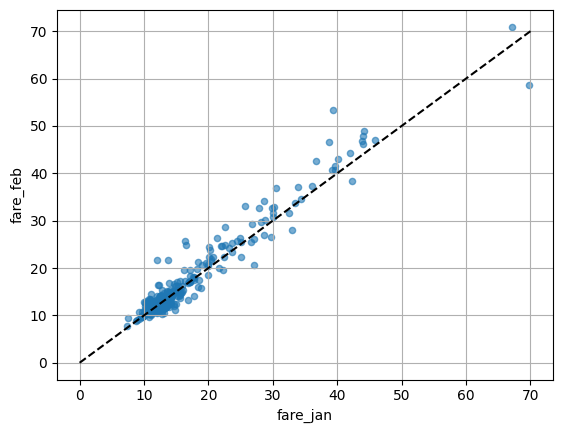

In [22]:
import matplotlib.pyplot as plt

df = out.df()

fig, ax = plt.subplots()
ax.plot([0,70], [0,70], color='k', linestyle='--')
df.plot.scatter(x='fare_jan', y='fare_feb', alpha=.6, ax=ax)
plt.grid()

# End-to-end example

In [3]:
import duckboat as uck

core = [
    'select *, h3_latlng_to_cell(pickup_latitude, pickup_longitude, 8) as hexid',
    'select hexid, avg(total_amount) as amount, count(*) as num group by 1',
    'select h3_h3_to_string(hexid) as hexid, amount, num',
]

core_with_filters = [
    'where (pickup_longitude != 0) and (pickup_latitude != 0)',
    'where total_amount > 0',
    core,
    'where num > 100',
]

db = uck.Database(
    t1 = uck.Table('data/yellow_tripdata_2010-01.parquet').do(core_with_filters),
    t2 = uck.Table('data/yellow_tripdata_2010-02.parquet').do(core_with_filters),
)

db.do("""
    select
        hexid,
        t1.amount  as  fare_jan,
        t2.amount  as  fare_feb,
    from        t1
    inner join  t2
    using       (hexid)
""",
    'select *, fare_feb - fare_jan as fare_change',
    'order by fare_change',
)

┌─────────────────┬────────────────────┬────────────────────┬─────────────────────┐
│      hexid      │      fare_jan      │      fare_feb      │     fare_change     │
│     varchar     │       double       │       double       │       double        │
├─────────────────┼────────────────────┼────────────────────┼─────────────────────┤
│ 882a1071adfffff │  69.73084615384616 │ 58.737914798206276 │ -10.992931355639882 │
│ 882a100c01fffff │ 27.110503597122307 │ 20.741372549019605 │  -6.369131048102702 │
│ 882a100e37fffff │  33.03063551401869 │  28.06555765595463 │   -4.96507785806406 │
│ 882a1072e7fffff │  42.25520958083832 │  38.42423076923077 │  -3.830978811607551 │
│ 882a1008e9fffff │ 17.742466666666665 │ 14.009843750000002 │ -3.7326229166666636 │
│ 882a1008e7fffff │ 14.852932330827068 │ 11.121284403669724 │ -3.7316479271573435 │
│ 882a107207fffff │ 16.860051282051284 │ 13.165116279069766 │ -3.6949350029815182 │
│ 882a100e85fffff │ 29.665849999999995 │ 26.645454545454545 │ -3.02039545454

In [4]:
t1 = uck.Table('data/yellow_tripdata_2010-01.parquet').do(core_with_filters)

In [6]:
print(t1.rel.explain())

┌───────────────────────────┐
│         PROJECTION        │
│    ────────────────────   │
│           hexid           │
│           amount          │
│            num            │
│                           │
│          ~0 Rows          │
└─────────────┬─────────────┘
┌─────────────┴─────────────┐
│           FILTER          │
│    ────────────────────   │
│        (num > 100)        │
│                           │
│          ~0 Rows          │
└─────────────┬─────────────┘
┌─────────────┴─────────────┐
│       HASH_GROUP_BY       │
│    ────────────────────   │
│         Groups: #0        │
│                           │
│        Aggregates:        │
│          avg(#1)          │
│        count_star()       │
│                           │
│          ~1 Rows          │
└─────────────┬─────────────┘
┌─────────────┴─────────────┐
│         PROJECTION        │
│    ────────────────────   │
│           hexid           │
│        total_amount       │
│                           │
│        ~